# Speech Recognition Project

# 1)- Importing key Modules

In [2]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [5]:
# installing new module
! pip install librosa

  Stored in directory: C:\Users\Hassan\AppData\Local\pip\Cache\wheels\ce\49\68\87ba660f30e3977f0778e39ee2e944629cd37c2a0ce41f9ff1
  Stored in directory: C:\Users\Hassan\AppData\Local\pip\Cache\wheels\b9\64\09\0b6417df9d8ba8bc61a7d2553c5cebd714ec169644c88fc012
  Stored in directory: C:\Users\Hassan\AppData\Local\pip\Cache\wheels\ff\4f\ed\2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [6]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

In [22]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
%matplotlib inline

# 2)- Exploring data

In some cases, we perform Features extraction to original data. It can be done by various algorithms

- Resampling
- VAD (Voice Activity Detection)
- Maybe padding with 0 to make signals be equal length
- Log spectrogram (or MFCC, or PLP)
- Features normalization with mean and std
- Stacking of a given number of frames to get temporal information



In [15]:
train_audio_path = '/Users/Hassan/Documents/Python work/Learning Projects/text2speech/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [16]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

### Nyquist theorem

For Frequencies are in range (0, 8000) 

Text(0.5, 0, 'Seconds')

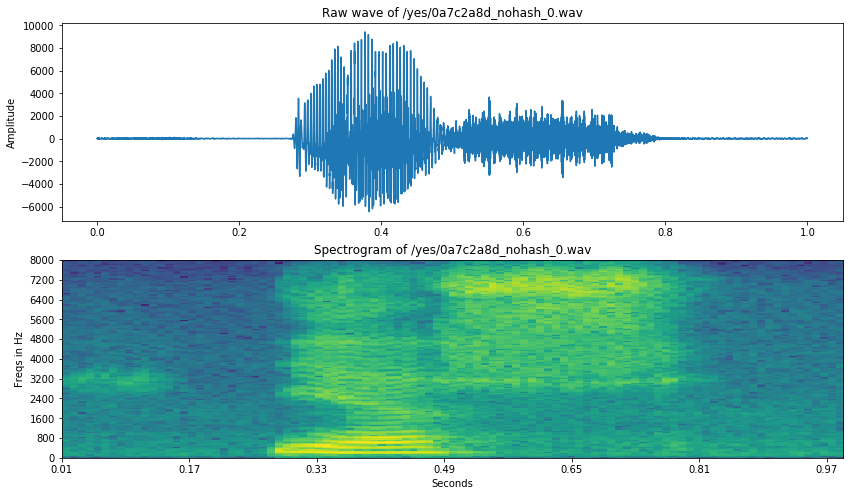

In [17]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### Normalize

we have to remember to normalize feature because we rarely work with a raw amplitude data.We may use **spectrogram** as an input features for neural nets

In [18]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

### MFCC

Mel Frequency Cepstral Coefficient is prepared to imitate human hearing properties.

http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

In [20]:
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

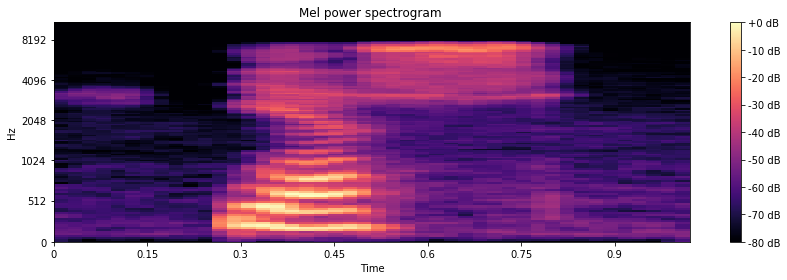

In [23]:
# We shall calculate Mel power spectrogram and MFCC using for example librosa python package.
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

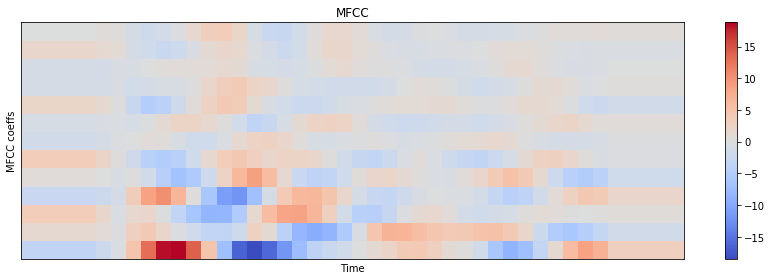

In [24]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

On paper, MFCC or similar features are taken as the input to the system instead of spectrograms.

For Neural Network, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well

### Silence removal

In [28]:
# listen to given data file
ipd.Audio(samples, rate=sample_rate)

In [29]:
#VAD (Voice Activity Detection). Let's cut a bit of the file from the beginning and from the end. and listen to it 
#again (based on a plot above, we take from 4000 to 13000)

samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

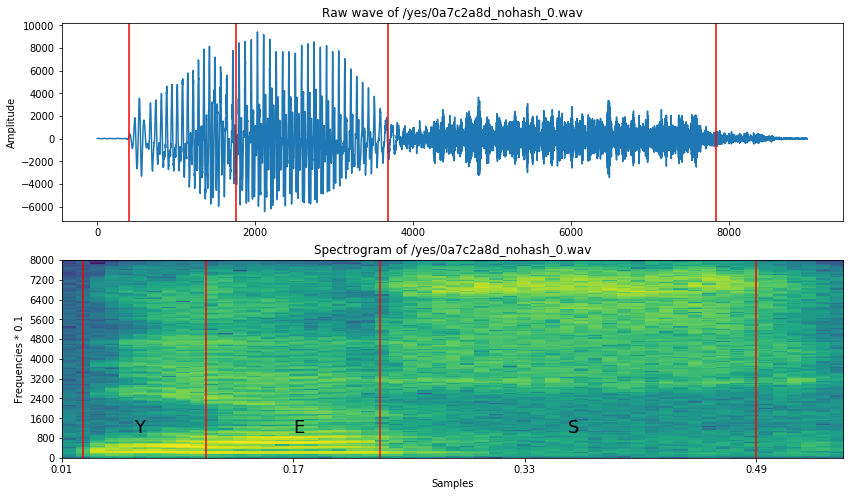

In [30]:
# Let's plot again

freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

### Resampling - dimensionality reduction

Another way to reduce the dimensionality of our data is to resample recordings.

In [31]:
#calculate FFT (Fast Fourier Transform).
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [32]:
#Let's read some recording, resample it, and listen
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [33]:
ipd.Audio(samples, rate=sample_rate)

In [34]:
ipd.Audio(resampled, rate=new_sample_rate)

These two speech patterns look very much same. Let's plot and see 

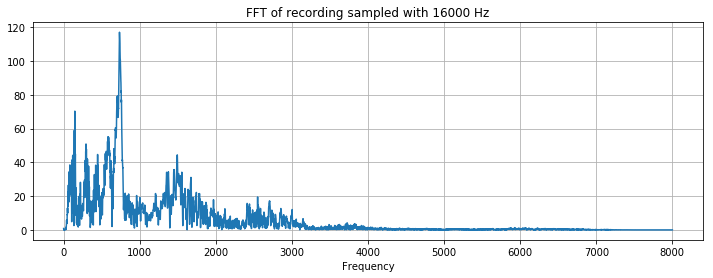

In [35]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

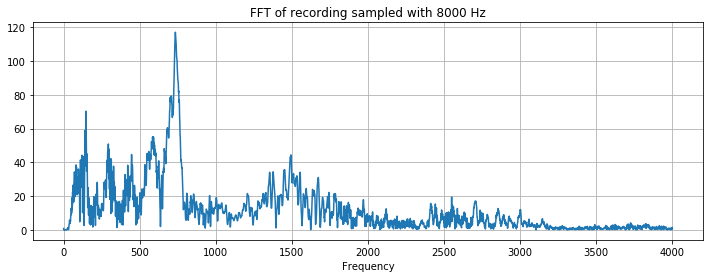

In [36]:
# for new sample
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

From two plots, we can clearly check how we reduced dataset size twice

# 3)- Getting to know data more !!!

### a)-Number of records

In [40]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 33


In [41]:
# using plotly

# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Blues', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

We can ignore 1st two entities as they are related to notebook format

For rest, Dataset is balanced except of background_noise.

### 3.2)- Recording sets

it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets

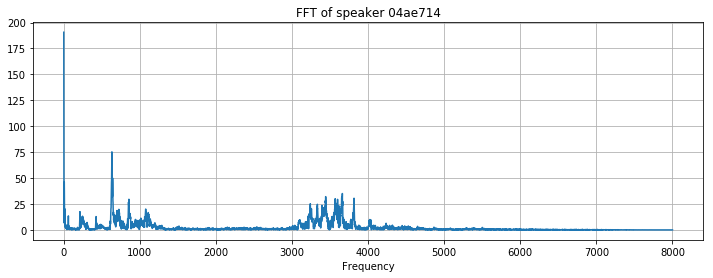

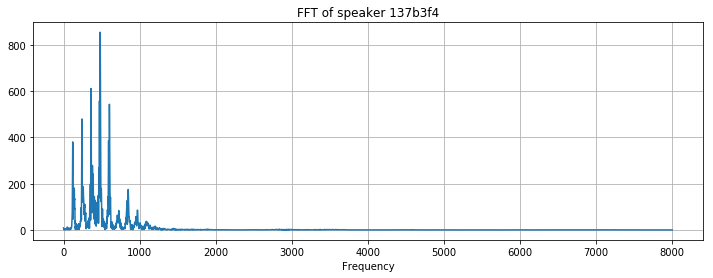

In [43]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

**Plot is good. Let's also listen them**

In [44]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [45]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 137b3f4


we have to prevent overfitting to the very specific

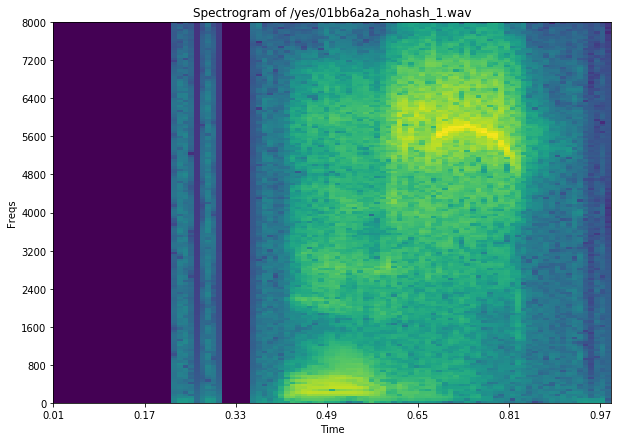

In [46]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

### 3.3)-Recordings length

In [47]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

C:\Users\Hassan\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Hassan\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Hassan\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Hassan\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


That's suprising, and there is a lot of them. We can pad them with zeros.

### 3.4)- Mean spectrograms and FFT

Let's plot mean FFT(Fast Fourier transform) for every word

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


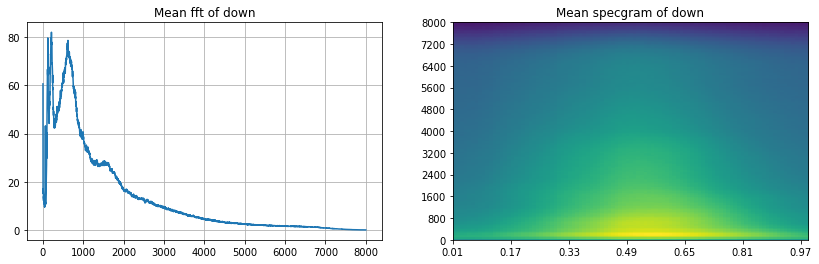

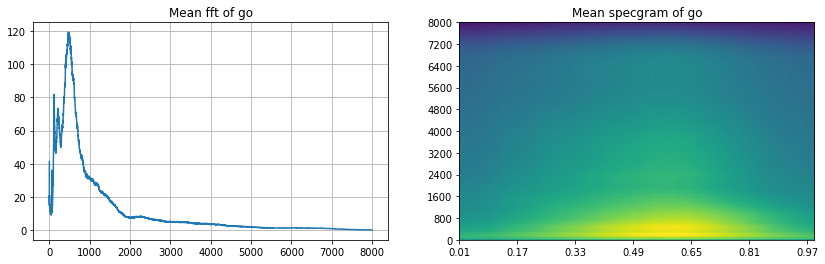

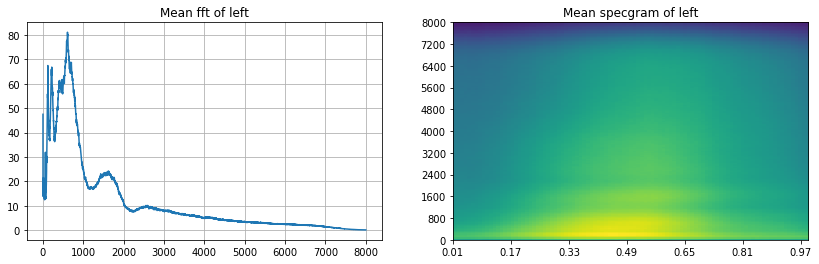

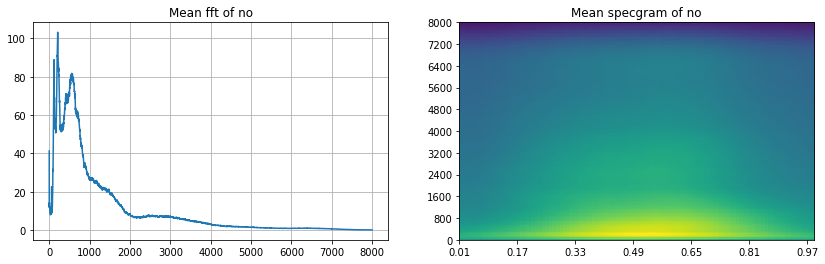

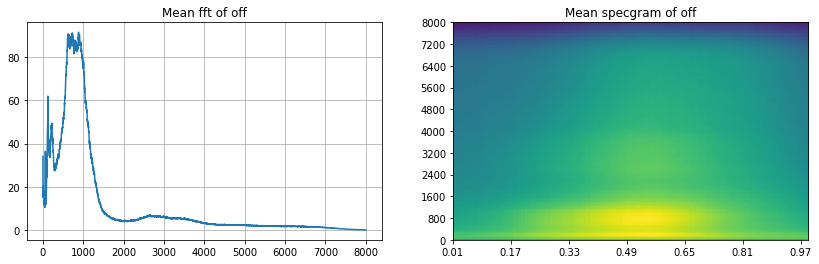

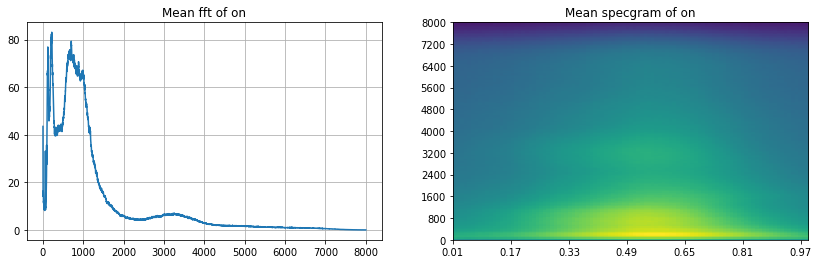

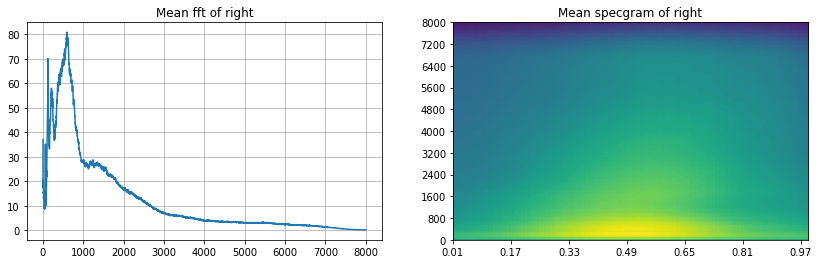

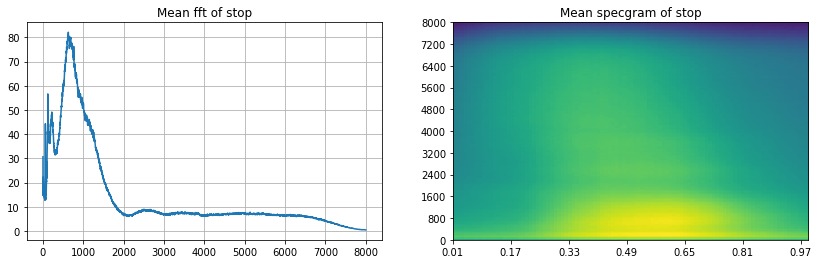

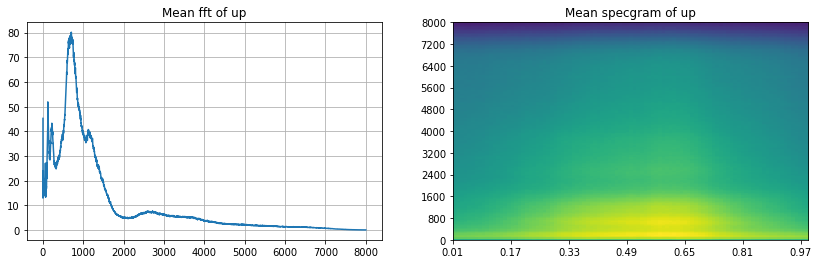

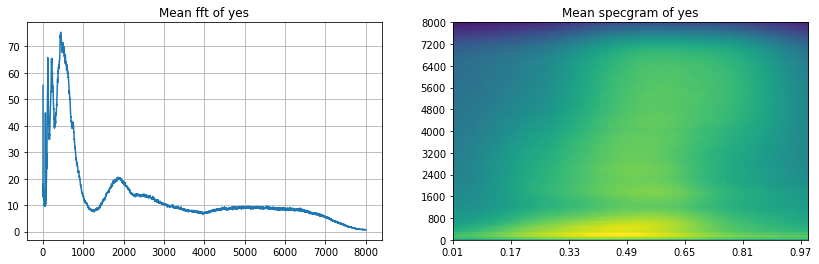

In [48]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

 - Gaussian Mixtures modeling

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words.

### 3.5)-Frequency components across the words

In [49]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

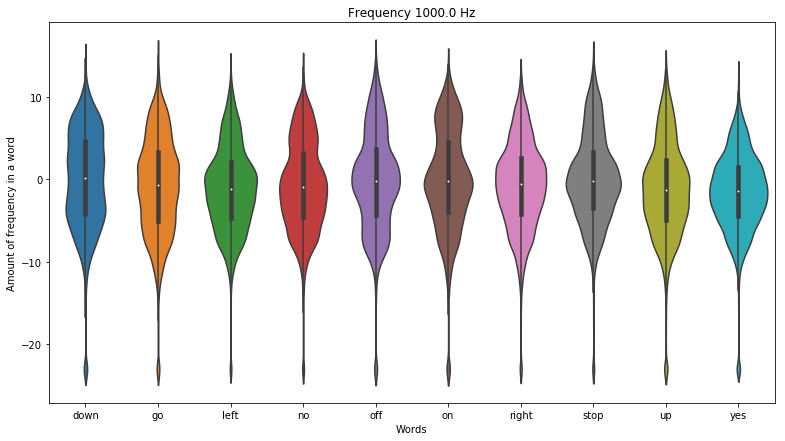

In [50]:
violinplot_frequency(dirs, 20)

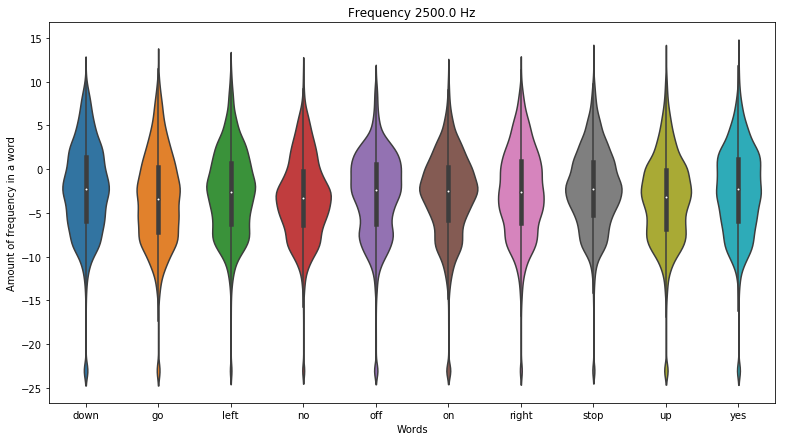

In [51]:
violinplot_frequency(dirs, 50)

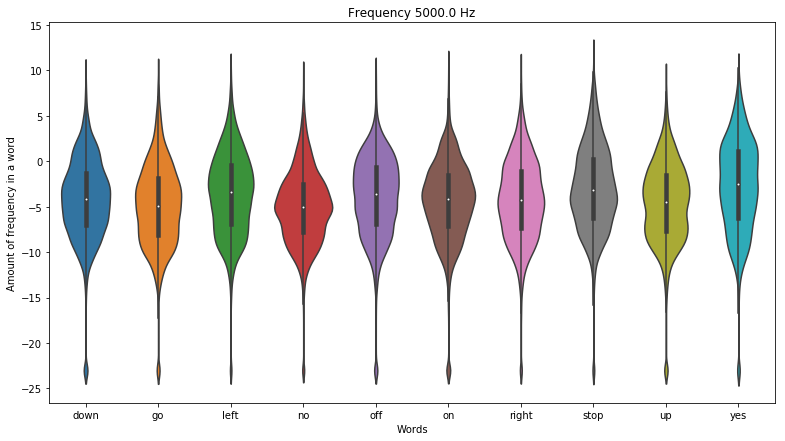

In [52]:
violinplot_frequency(dirs, 100)

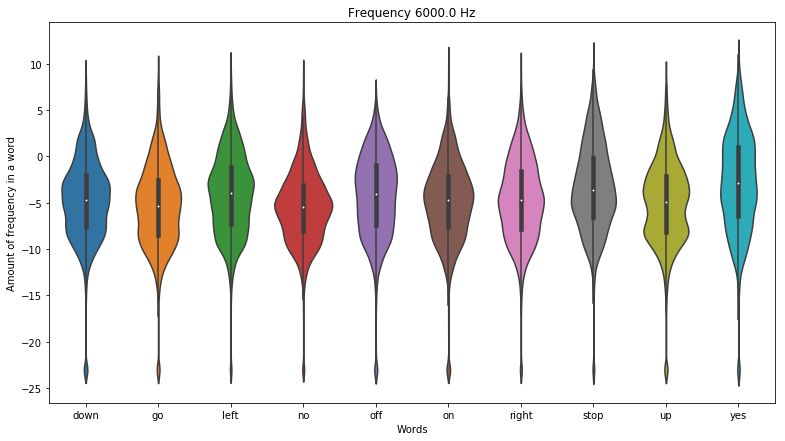

In [53]:
violinplot_frequency(dirs, 120)

### 3.6)-Dimensionality Reduction

We many check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality of the dataset. This step would help us in anomoly detection as well

In [54]:
# PCA
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

C:\Users\Hassan\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




yes/e4b02540_nohash_0.wav, down/a42a88ff_nohash_0.wav and more points, that lie far away from the rest

In [55]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


In [57]:
print('Recording down/a42a88ff_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'down/a42a88ff_nohash_0.wav'))

Recording down/a42a88ff_nohash_0.wav


In [58]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


In [59]:
#anomalies for individual words like this
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav


# 4)- Back to our problem statement.

Our goal is build our very own speech recognition model that is able to distinguish words.So, we shall work for it now 


Let's explore more files(including yes wave file) and add it to data. Rest of steps may remain same. 

In [2]:
DIR = '/Users/Hassan/Documents/Python work/Learning Projects/text2speech/'
fns = ['off/00b01445_nohash_0.wav',
       'go/00b01445_nohash_0.wav',
       'yes/00f0204f_nohash_0.wav']

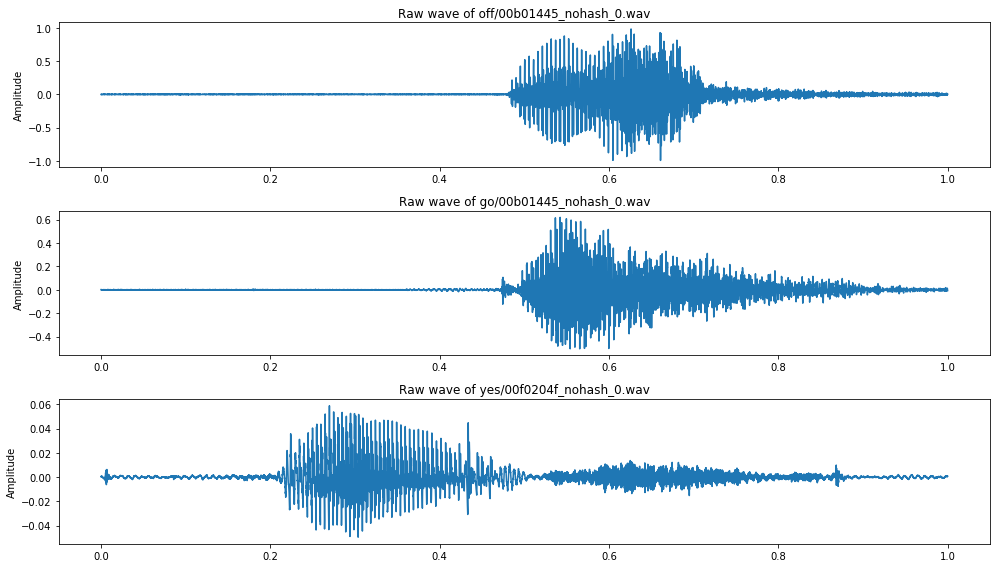

In [3]:
SAMPLE_RATE = 16000

def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav

fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)

    ax = fig.add_subplot(3,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()

# 5)-Embedding

Our sample variable i.e wav is just a vector with amplitudes in each time interval.We need to represent that pattern in a vector or matrix.Where, the procedure of representing a word in a vector or matrix form is called embedding.

- spectrograms

One dimensional vectors are easy to visualize, however, in speech recognition we rarely work with a raw amplitude data. The most common approaches are to convert audio files to spectrograms or MFCC (Mel-Frequency Cepstral Coefficients)

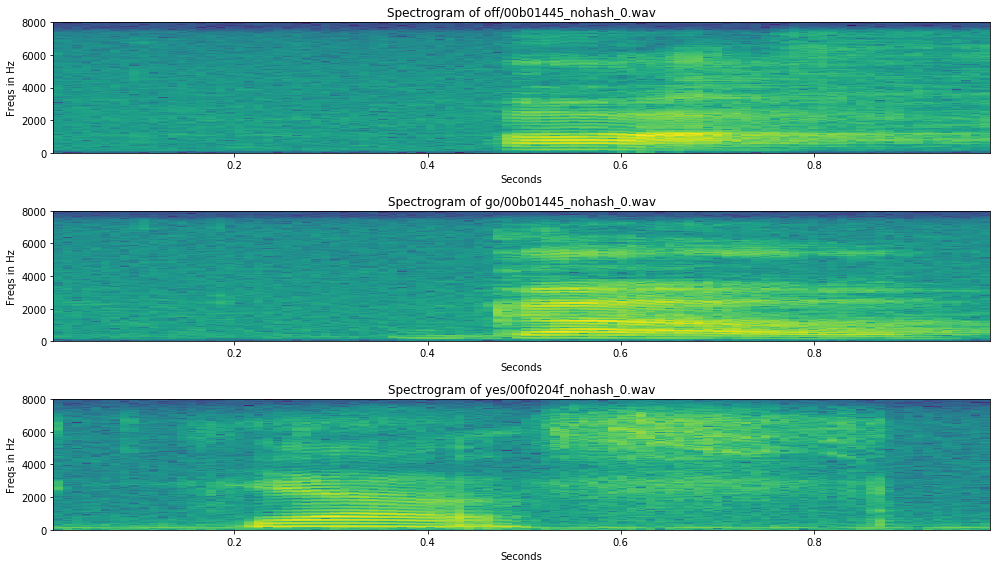

In [4]:
# import Short-time Fourier Transform (STFT).
#plot the log-spectrograms of three previously selected off, go and yes commands.
from scipy.signal import stft
 
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(3,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()

According to **Nyquist theorem** if sample rate equals 16000, then frequencies are in the range [0, 8000]. The image size is 177 x 98 (time x number of frames). Here is an interesting fact to note. The frequency resolution of the spectrogram is around 8000 / 98 ≈  80 Hz, whereas the human ear works in the resolution of 3.6 Hz, way more precise than spectrogram. Nevertheless, for our purposes, the current frequency resolution will be sufficient.

# 6) Modeling

- Prepare data for selected words including train/test split
- Convert raw data to log-spectrograms
- Train machine learning model
- Check accuracy on test data

In [ ]:
"""


# Creating DataGenerator class for getting data as dataframe
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        
"""

In [10]:
#We have converted data into log-spectrograms. So, now modeling steps. For this, we need to create dataframe
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from dataset import DatasetGenerator

 
DIR = '/Users/Hassan/Documents/Python work/Learning Projects/text2speech/' # unzipped train and test data
 
INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15
 
LABELS = 'yes no up'.split()
NUM_CLASSES = len(LABELS)

- The  DIR  variable is a location of extracted audio files.
- The  INPUT_SHAPE  variable is a size of log-spectrogram. Please note that we extend it to 3D array so that it can be used in Convolutional Neural Networks.
- BATCH  and  EPOCHS  are used in training of neural networks.
- LABELS  is a list of selected words and  NUM_CLASSES  is just the number of labels that will be predicted.

In [11]:
dsGen =  DatasetGenerator(label_set=LABELS) 
# Load DataFrame with paths/labels
df = dsGen.load_data(DIR)

In [13]:
df.head(5) 

label  label_id                user_id  \
0    no         1  012c8314_nohash_0.wav   
1    no         1  0132a06d_nohash_0.wav   
2    no         1  0132a06d_nohash_1.wav   
3    no         1  0132a06d_nohash_2.wav   
4    no         1  0132a06d_nohash_3.wav   

                                            wav_file  
0  /Users/Hassan/Documents/Python work/Learning P...  
1  /Users/Hassan/Documents/Python work/Learning P...  
2  /Users/Hassan/Documents/Python work/Learning P...  
3  /Users/Hassan/Documents/Python work/Learning P...  
4  /Users/Hassan/Documents/Python work/Learning P...

In [25]:
df.to_csv('speech.csv', index= False)

In [19]:
df.shape

(7127, 4)

**Our output labels*

In [15]:
df.label.value_counts()

yes    2377
no     2375
up     2375
Name: label, dtype: int64

### 6.1)- Spliting into train-test & train-Validation data

In [16]:
dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)

### 6.2)- Build neural network

In [21]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
                          
def deep(features_shape, num_classes, act='relu'):
 
    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(512, activation=act, name='dense1')(o)
    o = Dense(512, activation=act, name='dense2')(o)
    o = Dense(512, activation=act, name='dense3')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

### 6.3)- Model compile

In [22]:
model_nn = deep(INPUT_SHAPE, NUM_CLASSES)
model_nn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
flatten (Flatten)            (None, 17346)             0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               8881664   
_________________________________________________________________
dense2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense3 (Dense)               (None, 512)               262656    
_________________________________________________________________
pred (Dense)                 (None, 3)                 1539      
Total params: 9,408,515
Trainable params: 9,408,515
Non-trainable params: 0
_________________________________________________________________


### 6.4)- Fit the model

In [23]:
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]

history = model_nn.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

Epoch 1/15
125/125 [==============================] - 50s 398ms/step - loss: 10.5313 - acc: 0.3443 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 2/15
125/125 [==============================] - 22s 174ms/step - loss: 10.5768 - acc: 0.3438 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 3/15
125/125 [==============================] - 23s 181ms/step - loss: 10.5840 - acc: 0.3433 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 4/15
125/125 [==============================] - 23s 181ms/step - loss: 10.5822 - acc: 0.3435 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 5/15
125/125 [==============================] - 25s 197ms/step - loss: 10.5731 - acc: 0.3440 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 00005: early stopping


# 7)- Convolutional Neural Networks

Looking at trends of accuracy and validation accuracy, we might end up getting a plot where our model does not learn. Hence, we move to another algorithm i.e CNN model

In [27]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 

def deep_cnn(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)

    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

### 7.1)- compile & fit model

In [28]:
model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
 
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
 
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 177, 98, 32)       320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 49, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 89, 49, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 89, 49, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 25, 32)        0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 45, 25, 32)        128       
__________

### 7.2)- Evaluation

In [29]:
#To check whether our model generalizes well for unseen samples, let’s calculate the accuracy on the test data.
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)

67/67 [==============================] - 44s 650ms/step


In [30]:
print(y_pred_proba[:5])

[[5.3436557e-05 9.9981755e-01 1.2909868e-04]
 [1.3051814e-04 9.9986935e-01 8.7752127e-08]
 [3.5233997e-02 3.7896642e-01 5.8579957e-01]
 [8.0149010e-04 9.4239771e-02 9.0495872e-01]
 [9.9449968e-01 5.1925946e-03 3.0762903e-04]]


These are prediction values for class 0,1 and 2 i.e no, yes, off

In [31]:
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dsGen.df_test['label_id'].values

**Accuracy**

In [32]:
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

0.9121084618980833


**Other metrics of performance evaluation**

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       719
           1       0.84      0.97      0.90       738
           2       0.99      0.81      0.89       682

   micro avg       0.91      0.91      0.91      2139
   macro avg       0.92      0.91      0.91      2139
weighted avg       0.92      0.91      0.91      2139



Results are consistent for all three classes

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[686,  32,   1],
       [ 21, 715,   2],
       [ 28, 104, 550]], dtype=int64)

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

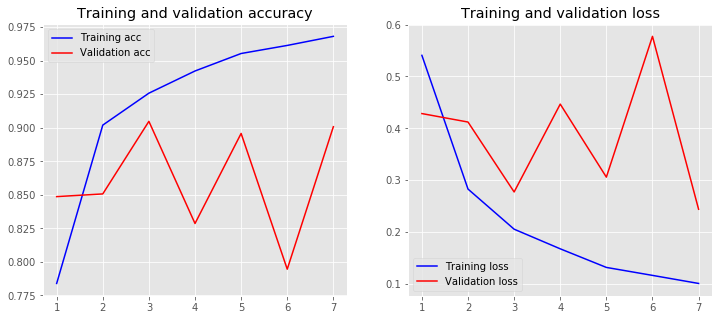

In [37]:
plot_history(history)